# This notebook compares various approaches of Text classification, based on Salesforce Case data, to classify the top 5 Reason codes. 

In [1]:
import os
import random

import numpy as np
import pandas as pd

# We read from the salesforce export data and check the first few rows

In [2]:
sfdc_data = pd.read_csv('C:/Users/GCNDP/SFDC.csv')
sfdc_data.head()

,Date,Subject*,Call Type,Assigned,Call Object Identifier,Call Recording,Case Number,Case Owner*,Case Subject,Case Status,Case Origin*,Reason*,Case Description,Count of Comments,Last Case Comment,Account Brand and Type,SAP ID,Account Name,Contact Name
0,11/15/2017,"Call 11/15/2017, 3:04:13 PM",Inbound,Debra Greenlee,104792934020171115,http://10.64.30.192:8091/?callid=1047929340,972606.0,Debra Greenlee,JDF credits,Closed,Phone,Credit,Valerie called about duplicate JDF credits on ...,1.0,Valerie called about duplicate JDF credits on ...,National - Dealer,1033841.0,MIDWAY CO-OP LURAY,Valerie Werthmann
1,6/7/2018,"Call 6/7/2018, 8:27:51 AM",Inbound,Debra Greenlee,304737374990180607,http://10.64.30.192:8091/?callid=3047373749,1296323.0,Debra Greenlee,Farmflex Financing reversal,Closed,Phone,Credit,Lisa called entered in a farmflex invoice in e...,1.0,Lisa called entered in a farmflex invoice in e...,National - Dealer,3383451.0,GREENPOINT AG ALTHEIMER,Lisa Waddle
2,5/10/2018,"Call 5/10/2018, 3:11:45 PM",Inbound,Debra Greenlee,304730318670180510,http://10.64.30.192:8091/?callid=3047303186,1267970.0,Debra Greenlee,New C3 user registration,Closed,Phone,Systems Support,Lisa Waddle needed assistance with registering...,1.0,Lisa Waddle needed assistance with registering...,National - Dealer,3383451.0,GREENPOINT AG ALTHEIMER,Lisa Waddle
3,3/7/2018,"Call 3/7/2018, 2:34:32 PM",Inbound,Debra Greenlee,204726086060180307,http://10.64.30.192:8091/?callid=2047260860,1144423.0,Debra Greenlee,MyMonsanto Issue,Closed,Phone,Manage Customer Accounts,"Rahul, Darrell Scott with SAP: 1032247 AGRI AF...",2.0,Darrell called trying access C3 User access to...,National - Dealer,1032247.0,AGRI AFC DECATUR,Darrell Scott
4,6/18/2018,"Call 6/18/2018, 10:09:15 AM",Inbound,Debra Greenlee,304740583190180618,http://10.64.30.192:8091/?callid=3047405831,1305717.0,Debra Greenlee,Farmflex,Closed,Phone,Credit,Jennie looking for farmflex credit on three gr...,1.0,Jennie looking for farmflex credit on three gr...,National - Dealer,3623699.0,TALLAHATCHIE F S CHARLESTON,Jennie Mullen


# We check the Reason codes and their counts in the data, since our main goal is to classify a Case into its correct Reason code

In [3]:
sfdc_data['Reason*'].value_counts()

Delivery/Shipments          70
Systems Support             50
Returns                     30
Credit                      21
Refusals                    14
Manage Customer Accounts    11
Programs/Compensation       11
Invoice                      8
Accounts Receivable          7
Compliance                   7
Quality Of Service           6
Order Management             6
Inventory                    4
Other                        3
Transfers/Swaps              2
Product                      2
Claims                       2
Pricing                      1
Collection                   1
Manage Sales partner         1
Name: Reason*, dtype: int64

In [4]:
sfdc_data['Account Brand and Type'].value_counts()

National - Dealer     120
Hubner - Dealer        75
Specialty - Dealer     23
Hubner - Grower        12
Channel - Dealer        7
Specialty - Grower      5
- Dealer                5
Jung - Dealer           2
Stone - Dealer          2
REA - Dealer            1
Stewart - Dealer        1
Lewis - Grower          1
Kruger - Grower         1
WestBred - Grower       1
National - Grower       1
Name: Account Brand and Type, dtype: int64

In [5]:
sfdc_data['Case Status'].value_counts()

Closed         254
In Progress      3
Name: Case Status, dtype: int64

In [6]:
sfdc_data['Call Type'].value_counts()

Outbound    151
Inbound     106
Name: Call Type, dtype: int64

# We filter out the five dominant reason codes for our analysis

In [4]:
#We take the four dominant reason codes
sfdc_data.rename(columns={'Reason*': 'Reason'}, inplace=True)
Reasons=['Delivery/Shipments','Systems Support','Returns','Credit','Refusals']
sfdc_data_filtered=pd.DataFrame(sfdc_data.loc[sfdc_data['Reason'].isin(Reasons)])

#reindex the filtered data
sfdc_data_filtered = sfdc_data_filtered.reset_index(drop = True)


In [6]:
sfdc_data_filtered['Reason'].value_counts()

Delivery/Shipments    70
Systems Support       50
Returns               30
Credit                21
Refusals              14
Name: Reason, dtype: int64

# We assign a numeric code to each of these Reason codes, as given here

In [5]:
sfdc_data_filtered.loc[(sfdc_data_filtered['Reason']=='Delivery/Shipments'),'label']='0'
sfdc_data_filtered.loc[(sfdc_data_filtered['Reason']=='Systems Support'),'label']='1'
sfdc_data_filtered.loc[(sfdc_data_filtered['Reason']=='Returns'),'label']='2'
sfdc_data_filtered.loc[(sfdc_data_filtered['Reason']=='Credit'),'label']='3'
sfdc_data_filtered.loc[(sfdc_data_filtered['Reason']=='Refusals'),'label']='4'

In [6]:
sfdc_data_filtered['label'].value_counts()

0    70
1    50
2    30
3    21
4    14
Name: label, dtype: int64

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer


def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 2),
                                          num_ngrams=50):
    """Plots the frequency distribution of n-grams.

    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': (1, 2),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    

    plt.figure(figsize=(20, 3))  # width:20, height:3
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    #plt.axis([0,20,0,160])
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()


def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()


def plot_class_distribution(labels):
    """Plots the class distribution.

    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    """
    num_classes = get_num_classes(labels)
    count_map = Counter(labels)
    counts = [count_map[i] for i in range(num_classes)]
    idx = np.arange(num_classes)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.title('Class distribution')
    plt.xticks(idx, idx)
    plt.show()

In [8]:
corpus = sfdc_data['Last Case Comment'].astype(str)
print(corpus[4])

Jennie looking for farmflex credit on three growers.


In [9]:
import re
import nltk
import string
exclude = set(string.punctuation) 
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
newStopWords = ['lb','j','df','jdf']
stop_words.extend(newStopWords)
table = str.maketrans('', '', string.punctuation)
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
   # doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I)
   # doc = doc.lower()
   # doc = doc.strip()
    # tokenize document
    tokens = doc.split()
    # remove punctuation from each word
    tokens = [w.translate(table) for w in tokens]
    #wpt.tokenize(doc)
    # convert to lower case
    lower_tokens = [w.lower() for w in tokens]
    #remove spaces
    stripped = [w.strip() for w in lower_tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter stopwords out of document
    filtered_tokens = [token for token in words if token not in stop_words]
    #apply Stemming
    #stemmed = [porter.stem(word) for word in filtered_tokens]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

# We tokenize the Case Description and normalize the text by removing punctuation, spaces, stop words, leading and trailing blanks

In [10]:
norm_corpus = normalize_corpus(corpus)
print(norm_corpus[15])

pam called wanted know grower paid full farm flex winfield invoice


In [11]:
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
stop_words = nltk.corpus.stopwords.words('english')
newStopWords = ['lb','j','df','jdf']
stop_words.extend(newStopWords)
wpt = nltk.WordPunctTokenizer()

def normalize_text(text):
    tokens = word_tokenize(text)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    words = [w for w in words if not w in stop_words]
    #print(words[:100])
    doc = ' '.join(words)
    return doc

# We check the median number of words per sample row

In [12]:
#Median number of words per sample
desc_text=sfdc_data['Last Case Comment'].astype(str)
num_words = [len(sfdc_data['Last Case Comment'].astype(str).str.split()) for s in desc_text]
print(np.median(num_words))

263.0


# Plot of frequency distribution of n-grams in the Case Description text

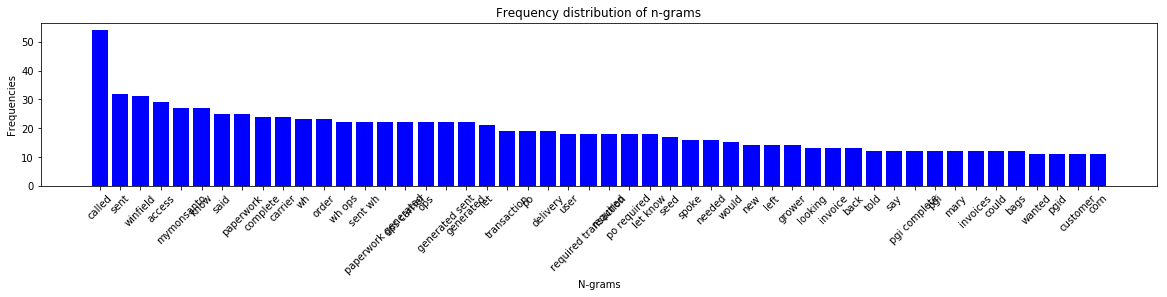

In [15]:
plot_frequency_distribution_of_ngrams(norm_corpus)

# Plot of length distribution of Case Description

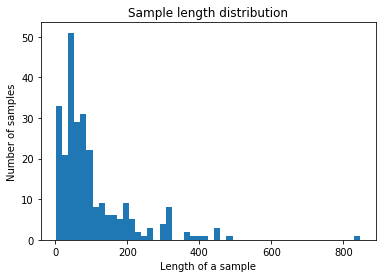

In [16]:
plot_sample_length_distribution(desc_text)

# Plot of Reason code distribution in the Case log

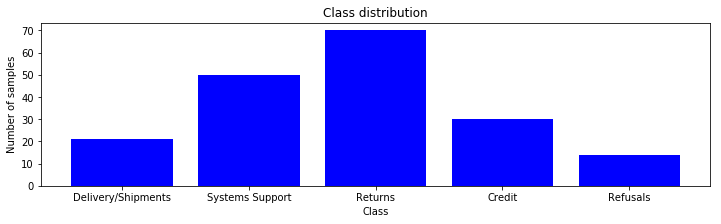

In [31]:
num_classes = 5
count_map = Counter(sfdc_data_filtered['label'])

counts = count_map.values()

[count_map[i] for i in range(num_classes)]
idx = ['Delivery/Shipments','Systems Support','Returns','Credit','Refusals']

plt.figure(figsize=(12, 3))  # width:20, height:3
plt.bar(idx, counts, width=0.8, color='b')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class distribution')
plt.xticks(idx, idx)
plt.show()

# We use StratifiedShuffleSplit to created train and test samples, and maintain same distribution of Reason codes in train and test set

In [13]:
#Distribution of reason codes in the filtered data
sfdc_data_filtered["label"].value_counts() / len(sfdc_data_filtered)

0    0.378378
1    0.270270
2    0.162162
3    0.113514
4    0.075676
Name: label, dtype: float64

In [14]:
#We use Stratifed Split to maintain the same distribution of Reason codes in Train and Test data
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)

for train_index, test_index in split.split(sfdc_data_filtered,sfdc_data_filtered["label"]):
    strat_train_set = sfdc_data_filtered.iloc[train_index]
    strat_test_set = sfdc_data_filtered.iloc[test_index]

In [15]:
#We see the train set has same distribution of reason codes as in original sample
strat_train_set["label"].value_counts() / len(strat_train_set)

0    0.378378
1    0.270270
2    0.162162
3    0.114865
4    0.074324
Name: label, dtype: float64

In [16]:
#We see the test set has same distribution of reason codes as in original sample
strat_test_set["label"].value_counts() / len(strat_test_set)

0    0.378378
1    0.270270
2    0.162162
3    0.108108
4    0.081081
Name: label, dtype: float64

In [17]:
train_texts=strat_train_set['Last Case Comment'].astype(str)
train_labels=strat_train_set['label'].astype(str)
train_texts=train_texts.reset_index(drop = True)
train_labels=train_labels.reset_index(drop = True)

# We print train and test texts, in the raw form

In [18]:
#We print some sample rows from train data, still the data is not in normalized form
print(train_texts[0])
print(train_labels[0])
print(len(train_texts))
print(train_texts[147])

Called Larry to let him know; he can now access grower orders in mymonsanto.
1
148
Paperwork generated and sent to WH, Ops, & Carrier


In [19]:
test_texts=strat_test_set['Last Case Comment'].astype(str)
test_texts=test_texts.reset_index(drop = True)
test_labels=strat_test_set['label'].astype(str)
test_labels=test_labels.reset_index(drop = True)

In [20]:
print(len(test_texts))
print(test_texts[0])
print(test_labels[0])
print(test_texts[36])
print(test_labels[36])

37
Mike, Jamie Pruitt called on Monsanto invoices do not flow overnight to Winfield on ASC/Winfield service center only; because invoices will be duplicated. Winfield manually matches up invoices with purchases orders to close out invoices on the Winfield side. Debra J. Greenlee Winfield at Monsanto
1
Ca
1


# We normalize the train and test data

In [21]:
norm_train_texts = []
for i in range (len(train_texts)):
    norm_train_texts.append(normalize_text(train_texts[i]))
    
print(train_texts[15])
print("after normalization")
print(norm_train_texts[15])

Spoke with Cindy. Shipping 1/31/2018 5007340229
after normalization
spoke cindy shipping


In [22]:
norm_test_texts = []
for i in range (len(test_texts)):
    norm_test_texts.append(normalize_text(test_texts[i]))

In [23]:
print(test_texts[0])
print("after normalization")
print(norm_test_texts[0])

Mike, Jamie Pruitt called on Monsanto invoices do not flow overnight to Winfield on ASC/Winfield service center only; because invoices will be duplicated. Winfield manually matches up invoices with purchases orders to close out invoices on the Winfield side. Debra J. Greenlee Winfield at Monsanto
after normalization
mike jamie pruitt called monsanto invoices flow overnight winfield ascwinfield service center invoices duplicated winfield manually matches invoices purchases orders close invoices winfield side debra greenlee winfield monsanto


# We create TF-IDF vectors with N-gram model from the train data (Case description text and reason codes)

In [25]:

import numpy as np


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Vectorization parameters

# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500


def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as ngram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of uni-grams + bi-grams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train)
    x_val = selector.transform(x_val)

    x_train = x_train.astype('float32')
    x_val = x_val.astype('float32')
    return x_train, x_val



In [26]:
# Vectorize texts.
x_train, x_test = ngram_vectorize(norm_train_texts, train_labels, norm_test_texts)

In [27]:
print(x_train.shape)
print(x_test.shape)

(148, 250)
(37, 250)


# We train Multinomial Naive Bayes and then check the accuracy (F1-score) on the test data

In [47]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

clf = MultinomialNB(alpha=.01)
clf.fit(x_train, train_labels)

pred = clf.predict(x_test)

print(metrics.f1_score(test_labels, pred, average='macro'))

0.8626984126984126


# Plot of ROC curve for mult-class classification with OneVsRestClassifier of SVM

In [48]:
# Binarize the output
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

train_labels_bin = label_binarize(train_labels, classes=['0','1', '2', '3', '4'])
n_classes = train_labels_bin.shape[1]
print(n_classes)
print(train_labels[0])
print(train_labels_bin[0])

5
1
[0 1 0 0 0]


In [29]:
test_labels_bin = label_binarize(test_labels, classes=['0','1', '2', '3', '4'])

In [41]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Train OneVsRestClassifier of SVM to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))
y_score = classifier.fit(x_train, train_labels_bin).decision_function(x_test)


In [72]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

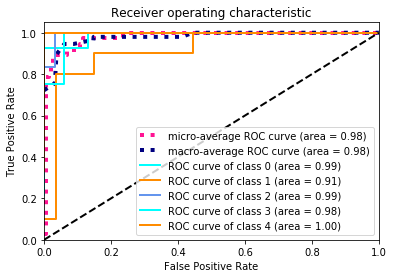

In [74]:
# Compute macro-average ROC curve and ROC area
from scipy import interp
from itertools import cycle
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [57]:
y_test = classifier.predict(x_test)
print(metrics.f1_score(test_labels_bin, y_test, average='macro'))

0.8337690631808279


# Extracting feature names

In [63]:
use_hashing = False
from time import time
from sklearn.feature_extraction.text import HashingVectorizer
print("Extracting features from the training data using a sparse vectorizer")
if use_hashing:
    vectorizer = HashingVectorizer(stop_words='english', alternate_sign=False,
                                   n_features=TOP_K)
    X_train = vectorizer.transform(norm_train_texts)
else:
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
    X_train = vectorizer.fit_transform(norm_train_texts)
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

X_test = vectorizer.transform(norm_test_texts)
print("n_samples: %d, n_features: %d" % X_test.shape)

Extracting features from the training data using a sparse vectorizer
n_samples: 148, n_features: 430

n_samples: 37, n_features: 430


In [81]:
print("Extracting %d best features by a chi-squared test")
from sklearn.feature_selection import SelectKBest, chi2
feature_names = vectorizer.get_feature_names()
#print(feature_names)

ch2 = SelectKBest(chi2, k=min(TOP_K, x_train.shape[1]))
x_train = ch2.fit_transform(x_train, train_labels)
x_test = ch2.transform(x_test)
if feature_names:
    # keep selected feature names
    feature_names = [feature_names[i] for i in ch2.get_support(indices=True)]
    print(feature_names)

Extracting %d best features by a chi-squared test
['able', 'access', 'accessing', 'accessmymon', 'accessto', 'account', 'actually', 'add', 'added', 'additional', 'adjusted', 'admin', 'aesoph', 'ag', 'agp', 'agreed', 'amanda', 'amy', 'andrew', 'anytime', 'approve', 'asked', 'asking', 'assistance', 'attached', 'aug', 'aware', 'bags', 'balance', 'barn', 'base', 'beans', 'beja', 'believed', 'bell', 'ben', 'benjamin', 'bennett', 'blocker', 'blytheville', 'bobbi', 'boxes', 'brent', 'brian', 'bucket', 'bufford', 'businesslink', 'called', 'care', 'carrier', 'case', 'cases', 'causing', 'cell', 'chance', 'change', 'changed', 'charges', 'charles', 'charlie', 'chelsea', 'chris', 'cindy', 'cjf', 'claims', 'closed', 'compatibility', 'complete', 'completed', 'confirm', 'confirmed', 'connect', 'conrad', 'contact', 'coop', 'copy', 'corn', 'county', 'create', 'created', 'credit', 'credits', 'cross', 'customer', 'dale', 'date', 'dates', 'dealer', 'dealership', 'debbie', 'del', 'delete', 'deleted', 'deliv

# Benchmarking Classifiers

In [88]:
# Benchmark classifiers
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
print_report=True
print_cm=True
print_top10=False
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(x_train, train_labels)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)
    target_names=train_labels
    t0 = time()
    pred = clf.predict(x_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(test_labels, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]).astype(str))))
        print()

    if print_report:
        print("classification report:")
        print(metrics.classification_report(test_labels, pred,
                                            target_names=train_labels))

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(test_labels, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

In [89]:
results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
train time: 0.023s
test time:  0.000s
accuracy:   0.865
dimensionality: 250
density: 1.000000

classification report:
             precision    recall  f1-score   support

          1       0.93      0.93      0.93        14
          0       0.78      0.70      0.74        10
          1       0.86      1.00      0.92         6
          1       0.75      0.75      0.75         4
          0       1.00      1.00      1.00         3

avg / total       0.86      0.86      0.86        37

confusion matrix:
[[13  1  0  0  0]
 [ 1  7  1  1  0]
 [ 0  0  6  0  0]
 [ 0  1  0  3  0]
 [ 0  0  0  0  3]]

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alph

C:\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:319: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
C:\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 5, does not match size of target_names, 148
  .format(len(labels), len(target_names))
C:\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 5, does not match size of target_names, 148
  .format(len(labels), len(target_names))
C:\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: Deprecat

train time: 0.122s
test time:  0.000s
accuracy:   0.757
classification report:
             precision    recall  f1-score   support

          1       0.67      1.00      0.80        14
          0       0.88      0.70      0.78        10
          1       0.67      0.33      0.44         6
          1       1.00      0.50      0.67         4
          0       1.00      1.00      1.00         3

avg / total       0.79      0.76      0.74        37

confusion matrix:
[[14  0  0  0  0]
 [ 2  7  1  0  0]
 [ 4  0  2  0  0]
 [ 1  1  0  2  0]
 [ 0  0  0  0  3]]



C:\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 5, does not match size of target_names, 148
  .format(len(labels), len(target_names))


In [90]:
for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty=penalty)))

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)
train time: 0.000s
test time:  0.000s
accuracy:   0.892
dimensionality: 250
density: 1.000000

classification report:
             precision    recall  f1-score   support

          1       0.93      1.00      0.97        14
          0       0.88      0.70      0.78        10
          1       0.86      1.00      0.92         6
          1       0.75      0.75      0.75         4
          0       1.00      1.00      1.00         3

avg / total       0.89      0.89      0.89        37

confusion matrix:
[[14  0  0  0  0]
 [ 1  7  1  1  0]
 [ 0  0  6  0  0]
 [ 0  1  0  3  0]
 [ 0  0  0  0  3]]

________________________________________________________________________________

C:\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 5, does not match size of target_names, 148
  .format(len(labels), len(target_names))
C:\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 5, does not match size of target_names, 148
  .format(len(labels), len(target_names))
C:\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 5, does not match size of target_names, 148
  .format(len(labels), len(target_names))
C:\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter 

In [92]:
from sklearn.feature_selection import SelectFromModel
# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=50,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
train time: 0.015s
test time:  0.003s
accuracy:   0.919
dimensionality: 250
density: 0.712800

classification report:
             precision    recall  f1-score   support

          1       0.93      1.00      0.97        14
          0       0.89      0.80      0.84        10
          1       1.00      1.00      1.00         6
          1       0.75      0.75      0.75         4
          0       1.00      1.00      1.00         3

avg / total       0.92      0.92      0.92        37

confusion matrix:
[[14  0  0  0  0]
 [ 1  8  0  1  0]
 [ 0  0  6  

C:\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 5, does not match size of target_names, 148
  .format(len(labels), len(target_names))
C:\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 5, does not match size of target_names, 148
  .format(len(labels), len(target_names))
C:\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 5, does not match size of target_names, 148
  .format(len(labels), len(target_names))
C:\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 5, does not match size of target_names, 148
  .format(len(labels), len(target_names)

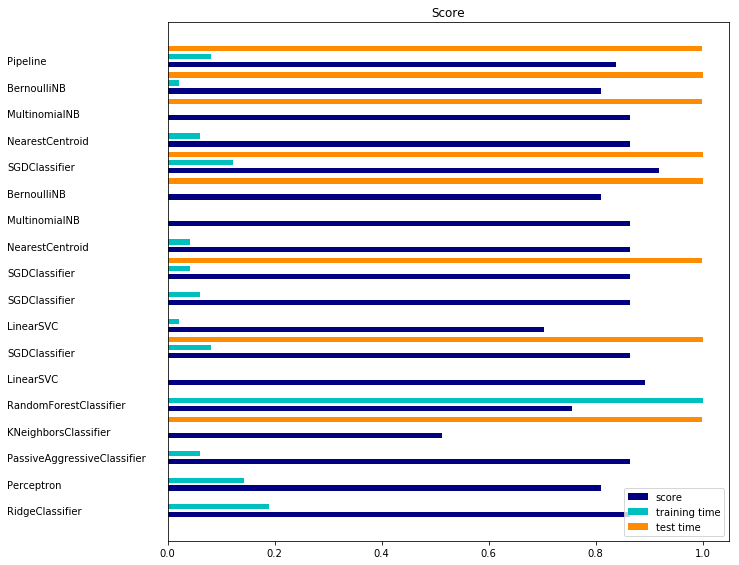

In [93]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()